In [1]:
import numpy as np
from get_border_cases import get_border_cases
import matplotlib.pyplot as plt

In [160]:
n = 17
N = n - 1
inner_n = n - 2
border_cases = get_border_cases(N)
params = np.ones(inner_n ** 2)



In [130]:
[(z // n, z % n) for z in sorted(border_cases)]

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (1, 0),
 (1, 8),
 (2, 0),
 (2, 8),
 (3, 0),
 (3, 8),
 (4, 0),
 (4, 8),
 (5, 0),
 (5, 8),
 (6, 0),
 (6, 8),
 (7, 0),
 (7, 8),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8)]

In [131]:
game = np.array([[7, 3], [4, 5]])
get_value(game.T), get_value(game)

(4.6, 4.6)

In [161]:
'''
    +
    Computes the value of a game.
    game is 2x2 matrix.
'''
def get_value(game):
    return (game[0, 0] * game[1, 1] - game[0, 1] * game[1, 0]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Compute optimal strategy for player 1.
'''
def get_p1(game):
    return (game[1, 1] - game[1, 0]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Compute optimal strategy for player 2.
'''
def get_q1(game):
    return (game[1, 1] - game[0, 1]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Converts global index to inner index.
    index - index to convert.
    inner_n - inner dimension (without borders).
    global_n - outer dimension (with borders).
'''
def inner_n_to_global_N(index, inner_n, global_n):
    row = index // inner_n
    col = index % inner_n
    global_index = (row + 1) * global_n + (col + 1)
    return global_index

def global_N_to_inner_n(index, inner_n, global_n):
    row = index // global_n
    col = index % global_n

    if row < 1 or col < 1 or row > global_n - 2 or col > global_n - 2:
        raise ValueError("Index should match an inner node.")
    inner_index = (row - 1) * inner_n + (col - 1)
    return inner_index

'''
    Checks if a game matrix has saddles.
'''
def check_for_saddle(game):
    maximin = np.max(np.min(game, axis=1))
    minimax = np.min(np.max(game, axis=0))
    res = 'N'
    if np.isclose(maximin, minimax, rtol=1e-8, atol=1e-8):
        res = maximin
        index = next(i for i, _ in enumerate(game.flatten()) if np.isclose(_, res, rtol=1e-8, atol=1e-8)) 
        return res, (1 - index // 2, 1 - index % 2) # fixed
    return 'N'
    
def get_game(index, w):
    game = np.zeros((2, 2))
    game[0, 0] = compute_a11(index, w)
    game[0, 1] = compute_a12(index, w)
    game[1, 0] = compute_a21(index, w)
    game[1, 1] = compute_a22(index, w)
    return game

# Up
def compute_a11(index, w):
    if (index - n) in border_cases:
        a11 = 1
    else:
        a11 = w[global_N_to_inner_n(index - n, inner_n, n)] + 1
    return a11
    
# Down
def compute_a21(index, w):
    if (index + n) in border_cases:
        a12 = 1
    else:
        a12 = w[global_N_to_inner_n(index + n, inner_n, n)] + 1
    return a12

# Right
def compute_a12(index, w):
    if (index + 1) in border_cases:
        a21 = 1
    else:
        a21 = w[global_N_to_inner_n(index + 1, inner_n, n)] + 1
    return a21

# Left
def compute_a22(index, w):
    if (index - 1) in border_cases:
        a22 = 1
    else:
        a22 = w[global_N_to_inner_n(index - 1, inner_n, n)] + 1
    return a22
    

'''
    Number of values in w should match number of equations.
'''
def prepare_equations(w):
    eqs = np.zeros(len(w))
    p1s = []
    q1s = []
    for i in range(len(w)):
        index = inner_n_to_global_N(i, inner_n, n)
        game_mx = get_game(index, w)
        saddle = check_for_saddle(game_mx)
        if saddle == "N":
            v = get_value(game_mx)
            p1 = get_p1(game_mx)
            q1 = get_q1(game_mx)
        else:
            v, (p1, q1) = saddle

        p1s.append(p1)
        q1s.append(q1)
        eqs[i] = w[i] - v

    return tuple(eqs)

In [133]:
game = np.array([[2, 3], [4, 5]])
game = np.array([[5, 4], [3, 2]])
game = np.array([[4, 4], [3, 3]])
res0 = np.max(np.min(game, axis=1))
res1 = np.min(np.max(game, axis=0))
print(game)
print(game.flatten())
print(res0, res1)
res = res0
index = next(i for i, _ in enumerate(game.flatten()) if np.isclose(_, res, rtol=1e-8, atol=1e-8)) 
print(index, (1 - index // 2, 1 - index % 2))

[[4 4]
 [3 3]]
[4 4 3 3]
4 4
0 (1, 1)


In [134]:
a = np.array([[2, 3], [4, 5]])
print(a)
np.max(np.min(a, axis=1))

[[2 3]
 [4 5]]


4

### Кто есть кто?

#### Кто Игрок 1, а кто Игрок 2 определяется через элементы матрицы игры a12 и a21.

#### Если a12 соответствует движению вправо, то Игрок 1 (выбирающий строки) - Центр, а Игрок 2 (выбирающий столбцы) - Граница. В таком случае a21 соответствует движению вниз.
#### Если a12 соответствует движению вниз, то Игрок 1 (выбирающий строки) - Граница, а Игрок 2 (выбирающий столбцы) - Центр. В таком случае a12 соответствует движению врпаво.

#### Сейчас a12 соответствует движению вправо.

In [166]:
from scipy.optimize import fsolve

#starting_params = np.random.random(inner_n ** 2) * (inner_n - 1) ** 2 * 0.68
#starting_params = starting_params.reshape(inner_n, inner_n)
#starting_params[1:-1, 1:-1] = np.array(vs).reshape(inner_n - 2, inner_n - 2)
#starting_params = starting_params.flatten()
#starting_params = np.ones(inner_n ** 2) * 3
w_new, _, _, message  = fsolve(prepare_equations, tuple(starting_params), full_output=True)
print(message)

The solution converged.


In [167]:
(inner_n - 1) ** 2 * 0.68, w_new.reshape(inner_n, inner_n)[inner_n // 2, inner_n // 2]

(133.28, 122.7632191138701)

In [154]:
starting_params

array([28.3731619 , 60.74661924, 18.73275129,  3.18719966, 53.65151542,
       51.71139237, 22.57937906, 53.41496911, 67.8620987 , 70.26128988,
       11.15789468,  6.35288591,  7.40210166, 37.34427347, 21.98880227,
       18.97527159, 54.46990433, 38.6981565 , 16.59901685, 45.27923637,
       67.82023506, 67.91333538,  4.49389629,  2.13748732, 26.57855055,
       61.12329116, 17.70039957,  3.18601853, 45.63158425, 37.32192267,
        5.6480098 , 68.66824947, 21.15703176, 40.6999785 , 41.42783584,
       56.29711757, 53.92242182, 16.12940268, 38.82957797, 11.27535705,
       21.62261094, 62.59012313, 20.61473992, 18.11627872, 35.98525144,
       33.07959525, 32.73780183,  4.3917432 , 27.01534545, 68.96616491,
       28.43076512, 40.78404381, 64.40928045,  9.97569587,  2.17389931,
       23.93895243, 46.69503707, 10.30118904, 21.86198124, 23.15827634,
       64.14844633, 19.15101948, 28.70541398, 70.50660298, 22.90586232,
        5.07783525, 22.51354559, 18.34005928, 12.03089462, 58.26

In [147]:
w_new.reshape(inner_n, inner_n)

array([[ 7.91588461, 13.83176922, 18.78905057, 23.11403577, 26.96205798,
        30.41775412, 33.52445451, 36.29005772, 38.67527664, 40.54934226,
        41.54934232],
       [13.83176922, 23.42040741, 31.00904561, 37.28080658, 42.55666307,
        47.00877818, 50.72055143, 53.69602805, 55.83370199, 56.83370197,
        40.54934226],
       [18.78905057, 31.00904561, 40.1750134 , 47.34098119, 53.00257635,
        57.43165588, 60.76831924, 63.0252118 , 64.0252118 , 55.83370199,
        38.67527664],
       [23.11403577, 37.28080658, 47.34098119, 54.72707243, 60.11316368,
        63.8824987 , 66.25965634, 67.25965634, 63.0252118 , 53.69602805,
        36.29005772],
       [26.96205799, 42.55666307, 53.00257635, 60.11316368, 64.73272981,
        67.35229594, 68.35229594, 66.25965634, 60.76831924, 50.72055143,
        33.52445451],
       [30.41775413, 47.00877818, 57.43165588, 63.8824987 , 67.35229594,
        68.35229592, 67.35229594, 63.8824987 , 57.43165588, 47.00877818,
        30.417

In [183]:
p1s = []
q1s = []
vs = []
for i in range(inner_n ** 2):
    index = inner_n_to_global_N(i, inner_n, n)
    game_mx = get_game(index, w_new)
    saddle = check_for_saddle(game_mx)


    print(f"index = {index}")
    print(f"game_mx:\n {game_mx}")
    print(f"saddle = {saddle}")
    if saddle == "N":
        v = get_value(game_mx)
        p1 = get_p1(game_mx)
        q1 = get_q1(game_mx)
        print(f"p1 form N: {p1}")
    else:
        v, (p1, q1) = saddle

    print(f"v = {v}")
    print(f"p1 = {p1}")
    print(f"q1 = {q1}")
    p1s.append(p1)
    q1s.append(q1)
    vs.append(v)

index = 18
game_mx:
 [[ 1.         17.01100053]
 [17.01100053  1.        ]]
saddle = N
p1 form N: 0.49999999999632955
v = 9.005500265521997
p1 = 0.49999999999632955
q1 = 0.5000000000036705
index = 19
game_mx:
 [[ 1.         23.05130169]
 [28.81564705 10.00550027]]
saddle = N
p1 form N: 0.4603396963875253
v = 16.011000531170982
p1 = 0.4603396963875253
q1 = 0.3192691867358651
index = 20
game_mx:
 [[ 1.         28.45512523]
 [38.62029357 17.01100053]]
saddle = N
p1 form N: 0.4404269692738098
v = 22.05130168735347
p1 = 0.4404269692738098
q1 = 0.23324692520675694
index = 21
game_mx:
 [[ 1.         33.38284844]
 [47.10916423 23.05130169]]
saddle = N
p1 form N: 0.42625016800046467
v = 27.455125227921652
p1 = 0.42625016800046467
q1 = 0.1830513219372413
index = 22
game_mx:
 [[ 1.         37.9278569 ]
 [54.61241642 28.45512523]]
saddle = N
p1 form N: 0.4146346958436595
v = 32.382848443609745
p1 = 0.4146346958436595
q1 = 0.15015787326745647
index = 23
game_mx:
 [[ 1.         42.14931187]
 [61.320

Text(0.5, 1.0, 'Mean absorption time')

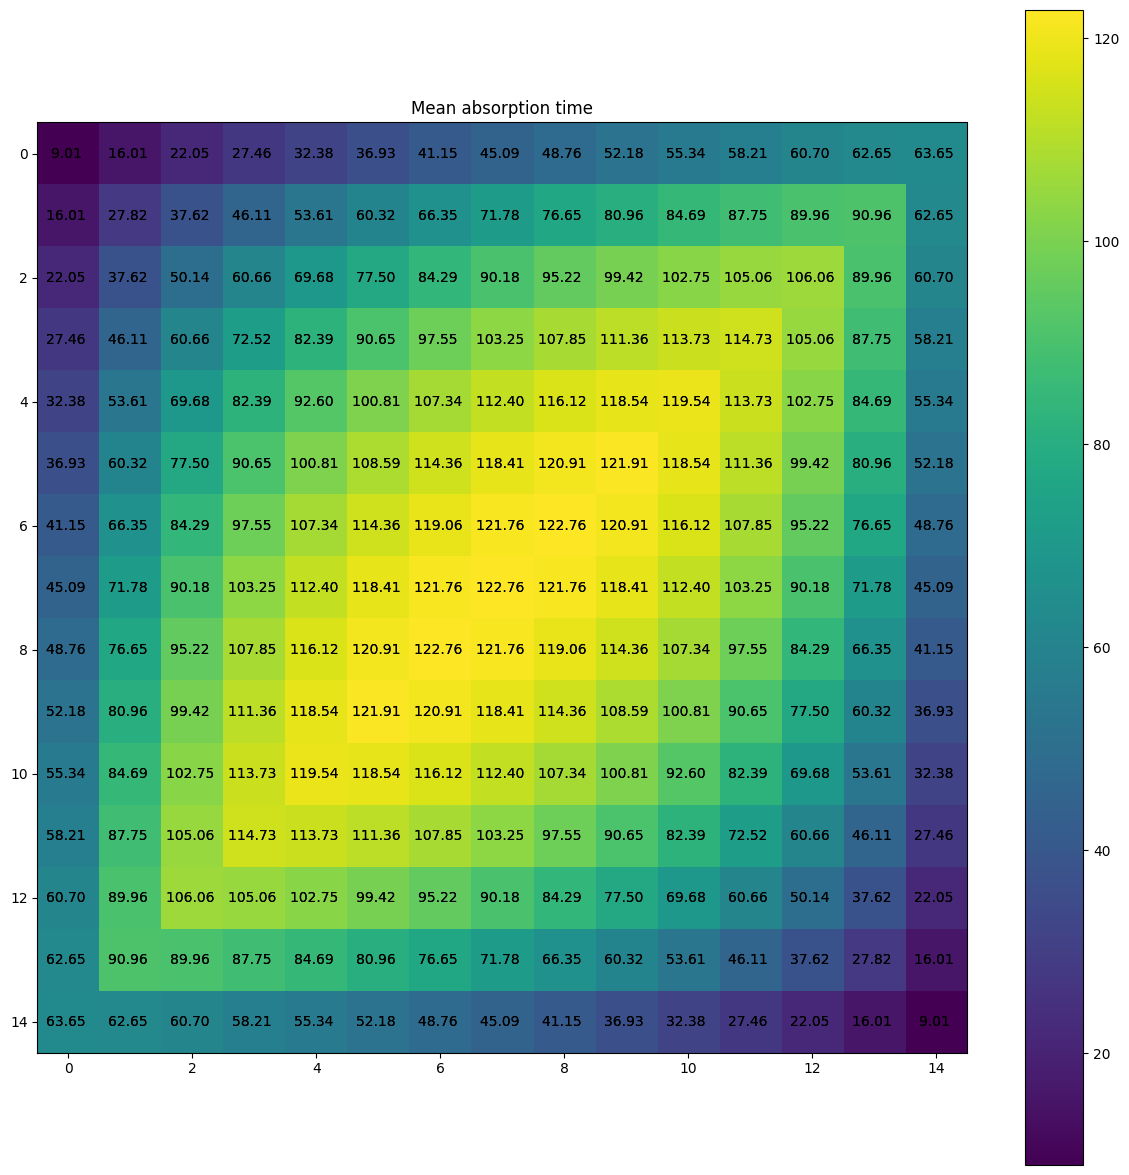

In [169]:
plt.figure(figsize=(15, 15))
plt.imshow(np.reshape(vs, newshape=(inner_n, inner_n)))
plt.colorbar()
for (j, i), label in np.ndenumerate(np.reshape(vs, newshape=(inner_n, inner_n))):
    #print_str_1 = "↑→" if np.isclose(label, 1) else ""
    #print_str_2 = "↓←" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} ", ha='center', va='center')
    plt.text(i, j, f"{label:.2f} ", ha='center', va='center')
    #print(label)
plt.title("Mean absorption time")

In [189]:
#np.diagonal(p1s)



array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.

Text(0.5, 1.0, 'Probability of choosing the 1st strategy for Player 1.')

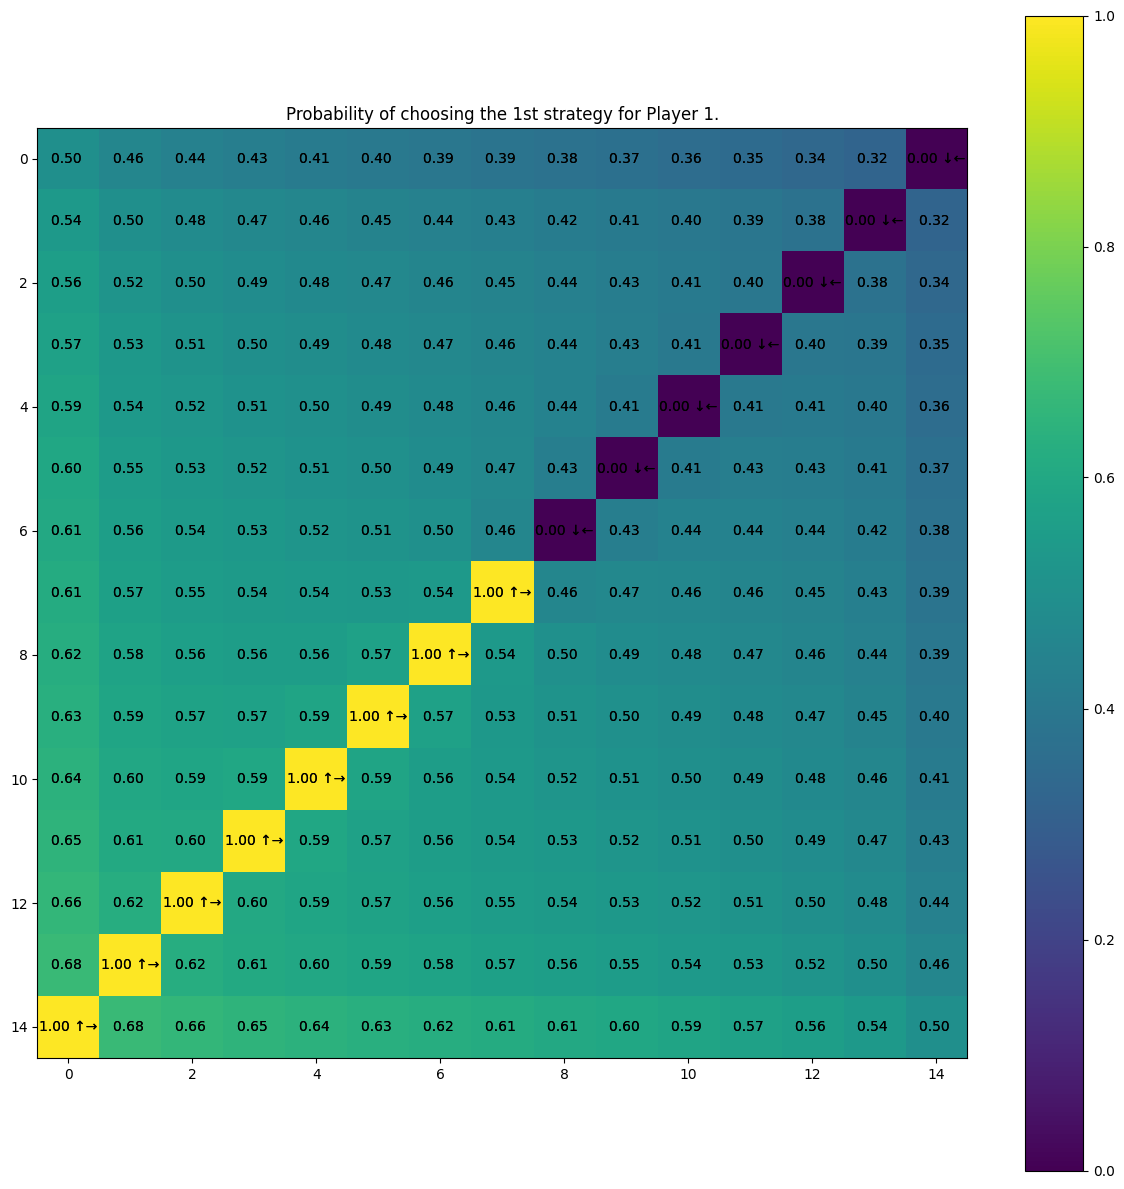

In [193]:
plt.figure(figsize=(15, 15))
plt.imshow(np.reshape(p1s, newshape=(inner_n, inner_n)))
plt.colorbar()
for (j, i), label in np.ndenumerate(np.reshape(p1s, newshape=(inner_n, inner_n))):
    print_str_1 = "↑→" if np.isclose(label, 1) else ""
    print_str_2 = "↓←" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    #print(label)
plt.title("Probability of choosing the 1st strategy for Player 1.")

Text(0.5, 1.0, 'Probability of choosing the 2nd strategy for Player 1.')

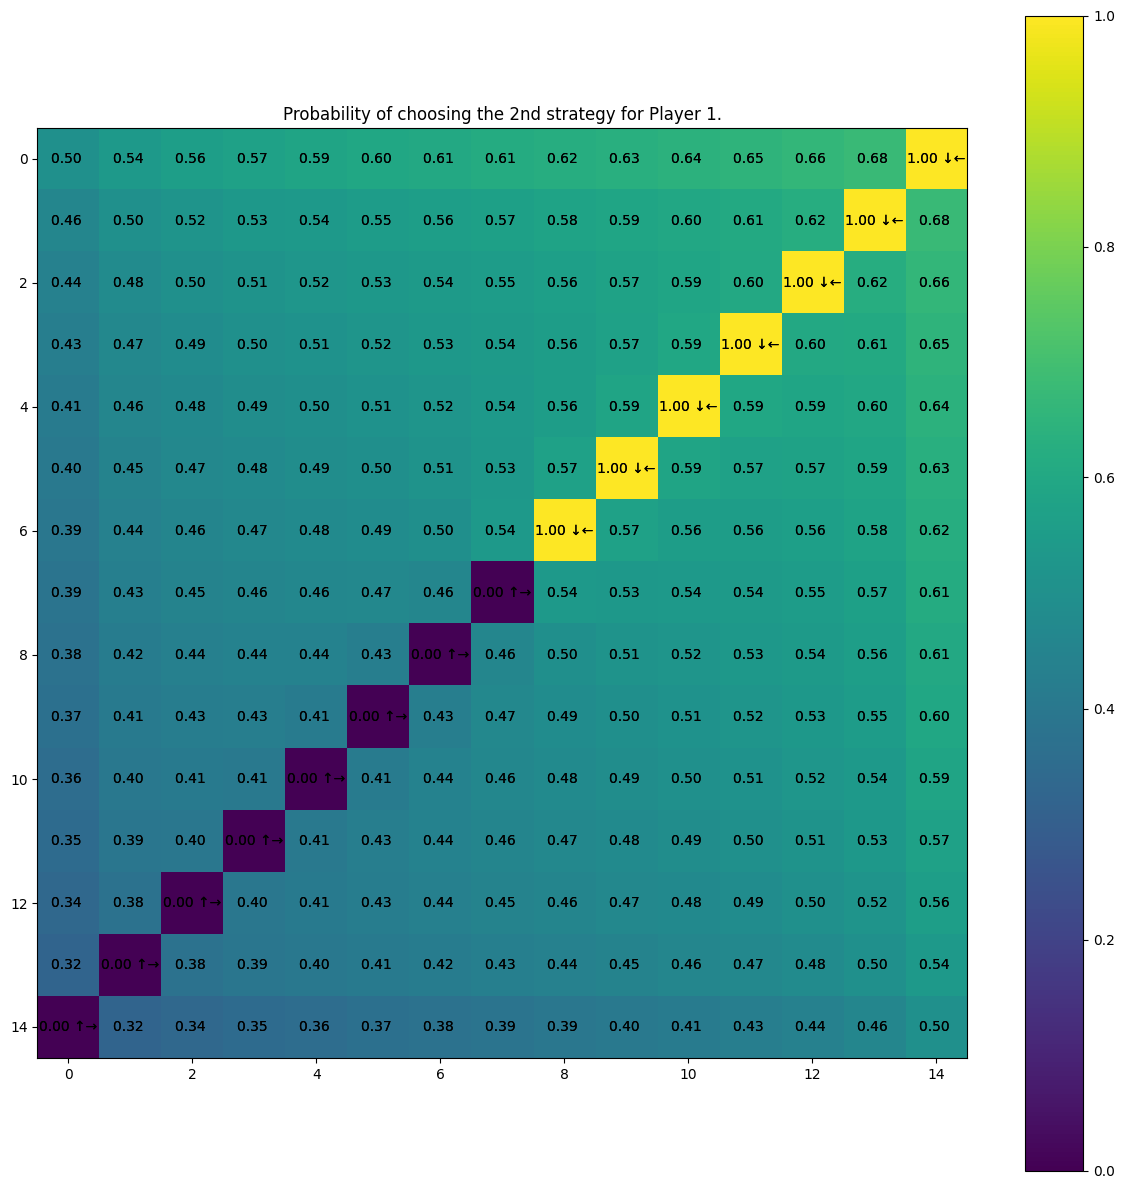

In [194]:
plt.figure(figsize=(15, 15))
plt.imshow(1 - np.reshape(p1s, newshape=(inner_n, inner_n)))
plt.colorbar()
for (j, i), label in np.ndenumerate(1 - np.reshape(p1s, newshape=(inner_n, inner_n))):
    print_str_1 = "↓←" if np.isclose(label, 1) else ""
    print_str_2 = "↑→" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    #print(label)
plt.title("Probability of choosing the 2nd strategy for Player 1.")

Text(0.5, 1.0, 'Probability of choosing the 1st strategy for Player 2.')

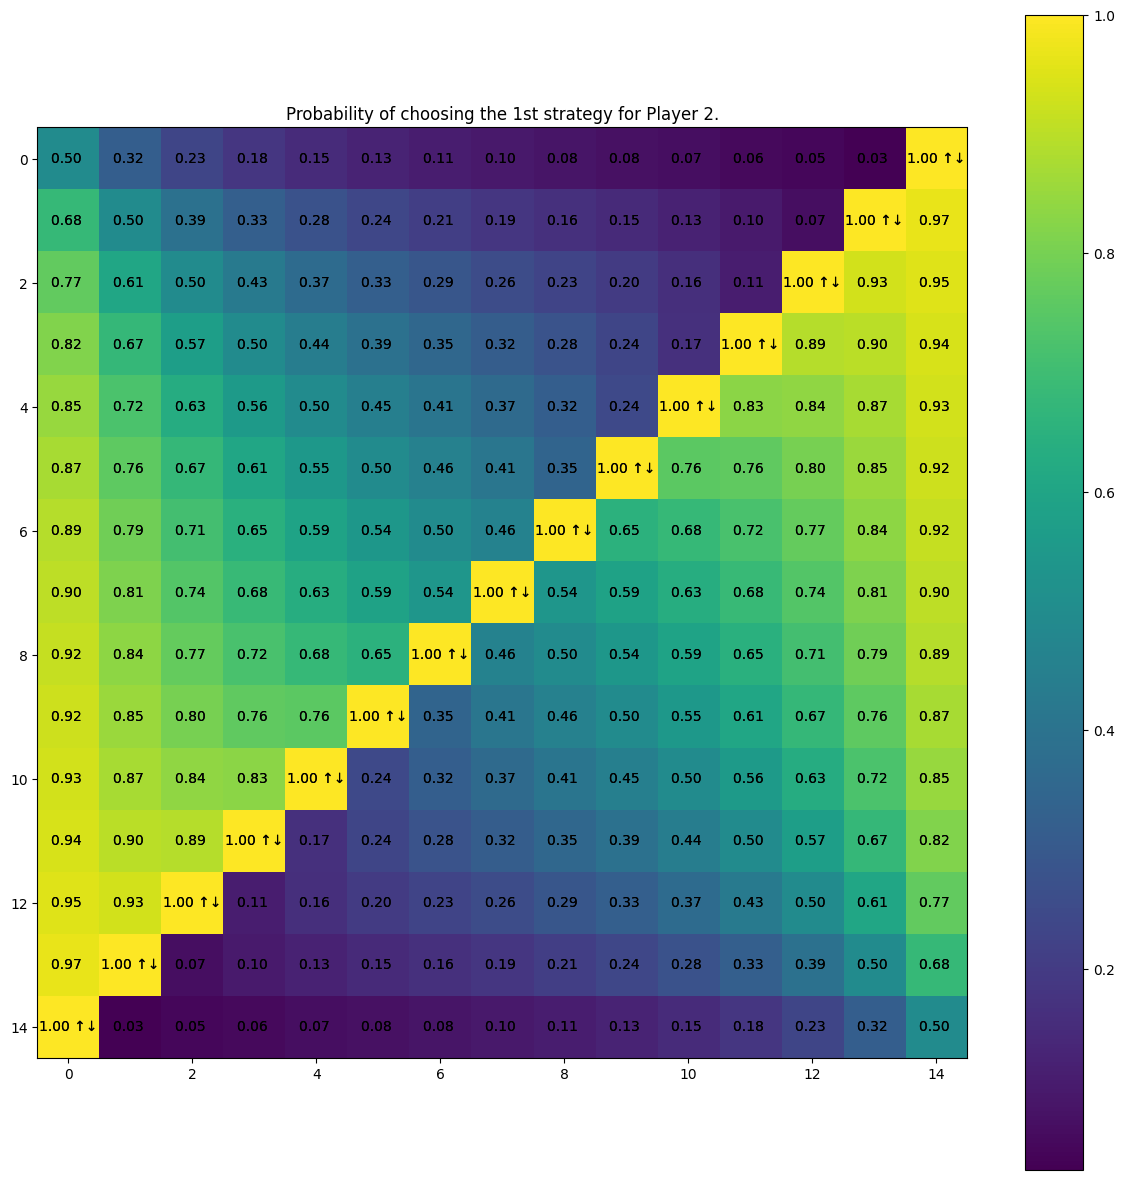

In [196]:
plt.figure(figsize=(15, 15))
q1s = np.array(q1s).reshape(inner_n, inner_n)
q1s_new = q1s - np.flipud(np.diag(np.diag(np.flipud(q1s)) - 0.5))
q1s_new = q1s.copy()
plt.imshow(np.reshape(q1s_new, newshape=(inner_n, inner_n)))

plt.colorbar()
for (j, i), label in np.ndenumerate(np.reshape(q1s_new, newshape=(inner_n, inner_n))):
    print_str_1 = "↑↓" if np.isclose(label, 1) else ""
    print_str_2 = "→←" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    #print(label)
plt.title("Probability of choosing the 1st strategy for Player 2.")